## Component 3. Topic Evolution in NIPS dataset

### Dynamic topic model(DTM) componet

Import the libraries.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import gensim
import json
import warnings
#warnings.filterwarnings('ignore')

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
pyLDAvis.enable_notebook()

from gensim import models, corpora
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import Phrases

from nltk import RegexpTokenizer
from nltk.corpus import stopwords, inaugural
from nltk.stem import PorterStemmer, WordNetLemmatizer

from collections import Counter

from pymongo import MongoClient

Load the paper texts as documents and record the time sequence of each year.

In [7]:
def load_doc(input):
    df = pd.read_csv(input)
    df.columns.get_values()
    documents = df['paper_text']
    documents.tolist()
    paper_year=df.groupby(['year']).size()
    time_seq = paper_year.tolist()
    return documents, time_seq

Natural Language Toolkit (NLTK) is applied to preprocess the documents. The process including:
    - Tokenise string.
    - Remove stop words
    - Remove non-letters
    - Convert letters to lower-case 
    - Remove words lee then three letters
    - Add bigrams
    - Filter out words occur less then 20 times and more then 50% of documents

In [25]:
def process_corpus(corpus): 
    wnl = WordNetLemmatizer()
    stops = stopwords.words('english')
    stops.extend(['figure','fig','pp','number','zero','one','two','three','four','five','six','seven','eight','nine','ten','across','among','beside','however','let','within','et','al'])
    processed_corpus = []
    tokenizer = RegexpTokenizer(r'[A-Za-z]+') # remove non-letters
    print('Cleaning the documents...')
    for document in corpus:
        document = ' '.join(tokenizer.tokenize(document)) # tokenise string
        document = [word for word in document.lower().split() if word not in stops] # convert to lower-case
        document = [word for word in document if len(word) > 3]  # remove all single-letter words
        document = [wnl.lemmatize(word) for word in document]  # lemmatize token
        processed_corpus.append(document)
    documents = processed_corpus
    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(documents, min_count=20)
    for idx in range(len(documents)):
        for token in bigram[documents[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                documents[idx].append(token)
                
    print('Building dictionary...')
    dictionary = Dictionary(documents)
    print('Number of unique tokens: %d' % len(dictionary))
    # Filter out words that occur too frequently or too rarely.
    max_freq = 0.5
    min_wordcount = 20
    dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)
    print('Number of unique tokens: %d' % len(dictionary))
    print('Building corpus...')
    corpus = [dictionary.doc2bow(doc) for doc in documents]
    return documents, dictionary, corpus

In [26]:
input = '/Users/lillian/Documents/workspace/ir/data/papers.csv'
docs, time_seq = load_doc(input)
documents, dictionary, corpus = process_corpus(docs)
MmCorpus.serialize('papers.mm', corpus)
dictionary.save('papers.dict')

Cleaning the documents...
Building dictionary...
Number of unique tokens: 153210
Number of unique tokens: 19146
Building corpus...


Run DTM model with 20 topics.

In [ ]:
# Load corpora and Dictionary
corpus = corpora.MmCorpus('papers.mm')
dictionary = Dictionary.load('papers.dict')
# Build DTM model
dtm_path = "/Users/lillian/Documents/workspace/dtm-master/dtm/dtm-main"
model = DtmModel(dtm_path, corpus, time_seq, num_topics=20,
                 id2word=dictionary, initialize_lda=True)
model.save('dtm_topic20')

In [4]:
def export_topics_csv(dtm_model, model_name, topics_n):
    df_topics = []
    topicid = topics_n
    num_words= 40
    for topicid in range(1, topicid+1):
        for time in range(0, 29):
            if time == 0:
                year1 = dtm_model.show_topic(topicid=topicid-1, time=time, topn=num_words)
                year2 = dtm_model.show_topic(topicid=topicid-1, time=time+1, topn=num_words)
                df1 = pd.DataFrame(year1,columns=[str(1987+time), 'Topic'+str(topicid)])
                df2 = pd.DataFrame(year2,columns=[str(1987+time+1), 'Topic'+str(topicid)])
                df_topics = df1.merge(df2, on='Topic'+str(topicid))   
            else:
                year3 = dtm_model.show_topic(topicid=topicid-1, time=time+1, topn=num_words)
                df3 = pd.DataFrame(year3,columns=[str(1987+time+1), 'Topic'+str(topicid)])
                df_topics = df_topics.merge(df3, on='Topic'+str(topicid))   

        df_topics.to_csv(model_name+'_topic'+str(topicid)+'.csv')
        del df_topics 

In [5]:
def export_dist_csv(dtm_model, model_name, topics_n):
    doc_number = 6560
    topics = topics_n
    distributions = []
    for j in range(0, doc_number):
        for i in range(0, topics):
            distribution = dtm_model.gamma_[j, i]
            distributions.append(distribution) 

    df_distribution = pd.DataFrame(distributions)
    df_distribution.to_csv(model_name+'_distribution.csv')

Export the model and data.

In [148]:
# Export the output data to csv files
topics_n = 20
model_name = 'dtm_topic20'
dtm_model = DtmModel.load('dtm_topic20')
export_topics_csv(dtm_model, model_name, topics_n)
export_dist_csv(dtm_model, model_name, topics_n)

In [5]:
def load_tableau10():
    # Scale the RGB values for "Tableau 10". 
    tableau10 = [(31, 119, 180), (255, 127, 14), (44, 160, 44),
                 (214, 39, 40), (148, 103, 189), (140, 86, 75),    
                 (227, 119, 194), (127, 127, 127), (188, 189, 34), (23, 190, 207)]  
    for i in range(len(tableau10)):    
        r, g, b = tableau10[i]    
        tableau10[i] = (r / 255., g / 255., b / 255.)   
    return tableau10

def load_tableau20():
    # Scale the RGB values for "Tableau 20". 
    tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    

    # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
    for i in range(len(tableau20)):    
        r, g, b = tableau20[i]    
        tableau20[i] = (r / 255., g / 255., b / 255.)     
    return tableau20
    
def visualize_topic_evolution(topic_n, path):
    topics = topic_n
    columns = ['Topic Models', 'Optimization', 'Deep learning', 'Supervised Learning', 'Graphs', 'Text Processing', 'Reinforcement Learning',
           'Neurobiology', 'Memory and Recurrent networks', 'Neural Networks', 'Regularization and Sparsity', 'Probability Distributions', 
           'Clustering', 'Adversarial settings and Bandits', 'Theorems and Proofs', 'Speech Processing', 'Human Cognition', 
           'Dimension reduction and Metric learning', 'Human Visual System', 'Computer Vision' ]
    for topic in range (1,topics+1):
        input = path+'topic'+str(topic)+'.csv'
        df = pd.read_csv(input)

        words = df['Topic'+str(topic)]
        probs = df.drop(['Topic'+str(topic)], axis=1)
        probs = probs[0:10]
        probs = probs.T
        probs = probs[1:31]

        ax = probs.plot(title=columns[topic-1], color=tableau)
        lgd = ax.legend(words[0:10], loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
        fig = ax.get_figure()
        fig.savefig('topic'+str(topic)+'evolution.eps', format='eps', dpi=1200, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [3]:
def visualize_distribution_evolution(topic_n, path):
    topics = topic_n
    years = 30
    tt=[]
    tmp_distribution= []
    columns = ['Topic Models', 'Optimization', 'Deep learning', 'Supervised Learning', 'Graphs', 'Text Processing', 'Reinforcement Learning',
           'Neurobiology', 'Memory and Recurrent networks', 'Neural Networks', 'Regularization and Sparsity', 'Probability Distributions', 
           'Clustering', 'Adversarial settings and Bandits','Theorems and Proofs', 'Speech Processing', 'Human Cognition', 
           'Dimension reduction and Metric learning', 'Human Visual System', 'Computer Vision' ]
    topics_list = ["Topic"+str(i) for i in range(1, topics+1)]
    input = path+'distribution.csv'
    df = pd.read_csv(input, sep=',')
    tmp = df['0'].values.reshape(6560, topics) 
    dis = pd.DataFrame(tmp)
    for year in range(0,years):
        for i in range(0,topics):
            if year == 0:
                tmp_distribution.append(sum(dis[i].iloc[0:time_seq[0]])/time_seq[0])
            else:
                tmp_distribution.append( sum(dis[i].iloc[time_seq[year-1]:time_seq[year-1]+time_seq[year]]) / time_seq[year] )

    year_distribution = pd.DataFrame(np.array(tmp_distribution).reshape(years, topics), 
                                     index=range(1987,1987+years), columns=columns)

    #year_distribution.plot.bar(stacked=True , color=tableau20)
    ax = year_distribution.plot(title='Topic evolution', color=tableau)
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    fig = ax.get_figure()
    fig.savefig('topic distribution.eps', format='eps', dpi=1200, bbox_extra_artists=(lgd,), bbox_inches='tight')


Visualize top-30 words in each topic.

In [3]:
# Load corpora and model
def load_dtm_model(model_name):
    corpus = corpora.MmCorpus('papers.mm')
    dictionary = Dictionary.load('papers.dict')
    dtm_model = DtmModel.load(model_name)
    return corpus, dictionary, dtm_model
corpus, dictionary, dtm_model = load_dtm_model('dtm_topic20_2')

In [53]:
# Visualize top-30 words in each topic
time=17
#corpus = corpora.MmCorpus('papers.mm')
#dictionary = Dictionary.load('papers.dict')
#dtm_model = DtmModel.load('dtm_topic10_1016')
doc_topic, topic_term, doc_lengths, term_frequency, vocab = dtm_model.dtm_vis(time=time, corpus=corpus)
vis = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.save_html(vis,'dtm_topic20_2004.html')
pyLDAvis.display(vis)

Visualize topic evolution and topics distribution.

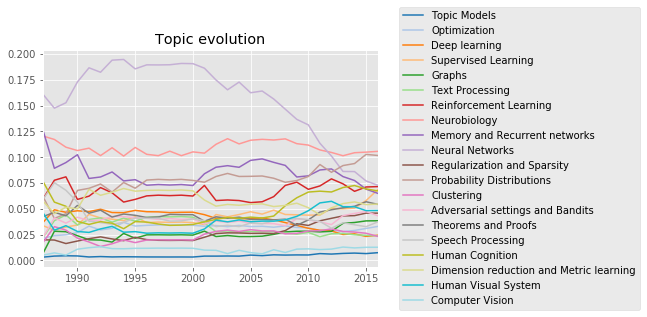

In [9]:
# visualize topics distribution
topics_n = 20
path = '/Users/lillian/Documents/workspace/ir/dtm_20_'
tableau=load_tableau20()
visualize_distribution_evolution(topics_n, path)

Topic3 and Topic4 have relative higher proportion and both of them are correlated to neural network. But Topic4 is declined after 2000.

The 20 topics are defined as:
    - 1. Topic Models
    - 2. Optimization
    - 3. Deep learning
    - 4. Supervised Learning
    - 5. Graphs
    - 6. Active learning
    - 7. Reinforcement Learning
    - 8. Neurobiology
    - 9. Circuits/Hardware
    - 10. Neural Networks
    - 11. Images
    - 12. Bayesian Inference/Sampling
    - 13. Graphs
    - 14. Entropy/Energy Functions
    - 15. Theorems/Proofs
    - 16. Speech/Text Processing
    - 17. Human Cognition
    - 18. Dimension Reduction/Metric Learning
    - 19. Human Visual System
    - 20. Learning theory 

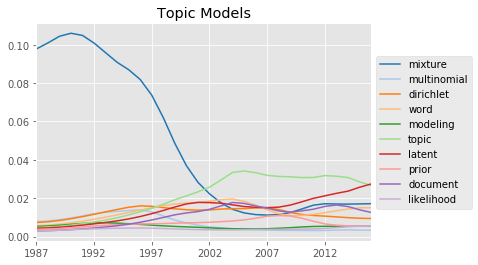

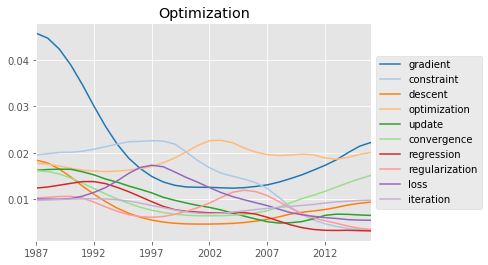

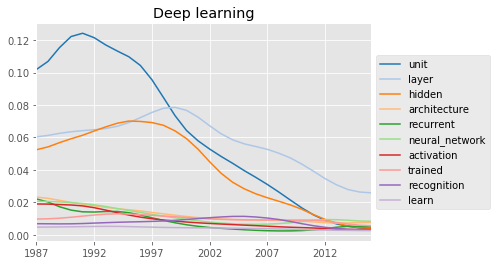

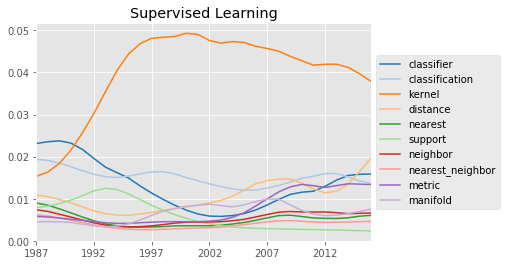

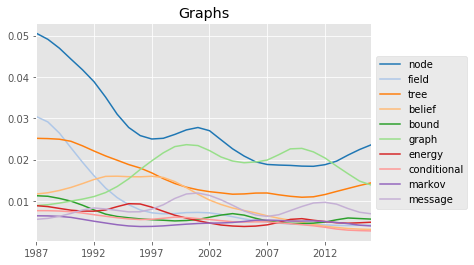

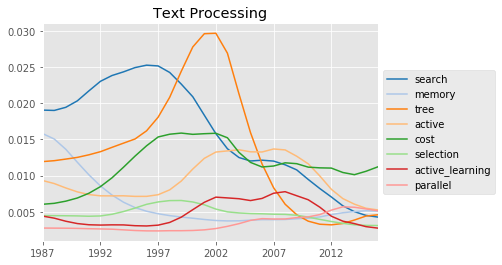

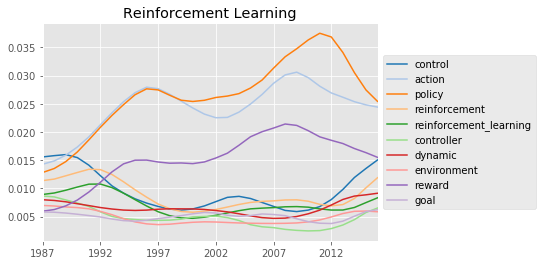

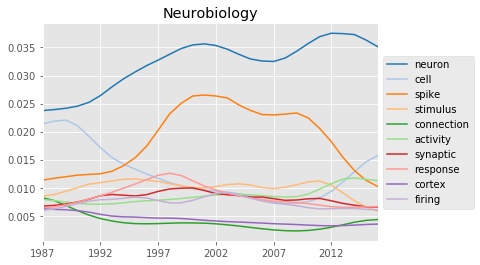

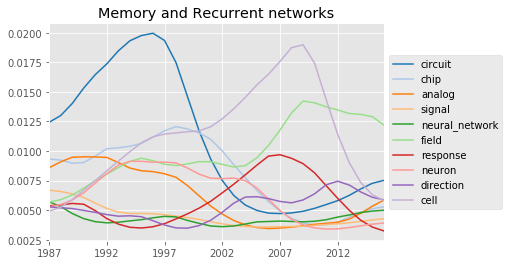

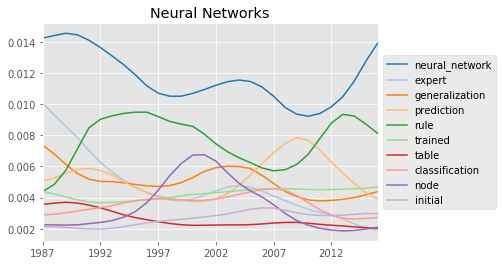

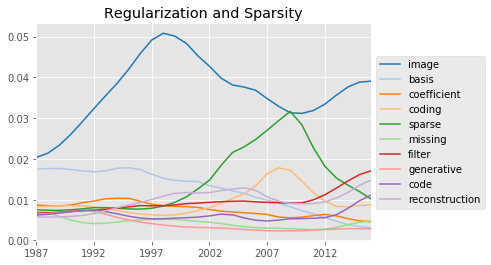

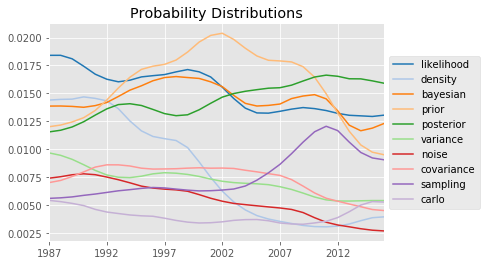

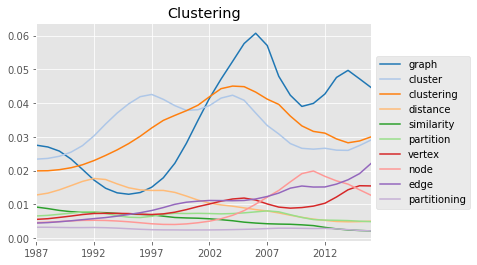

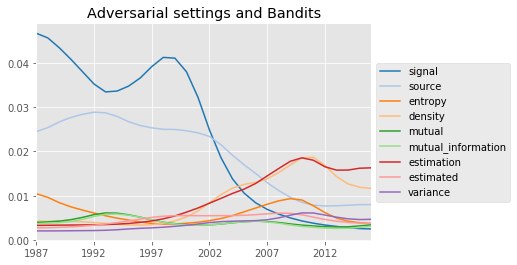

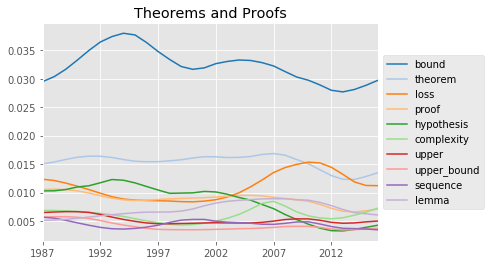

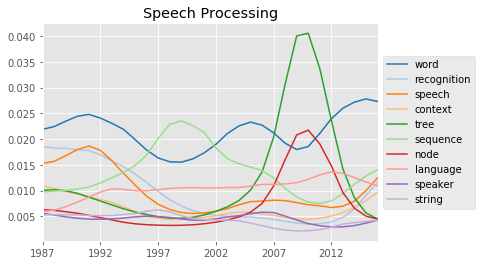

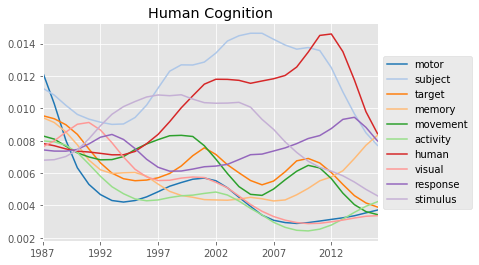

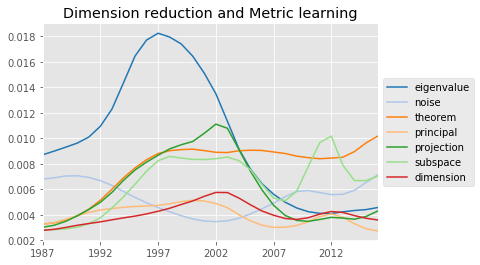

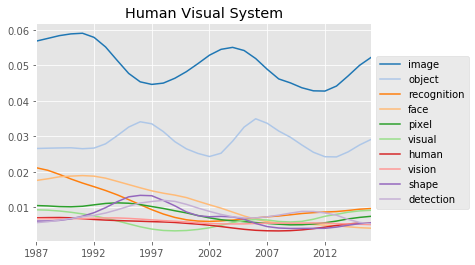

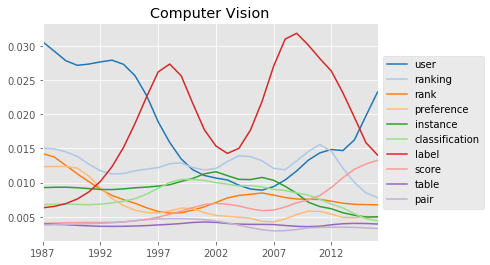

In [53]:
# Visualize topic evolution
visualize_topic_evolution(topics_n, path)

In [34]:
df_topics = []
topicid = 20
num_words= 30
count_words = []
for topicid in range(1, topicid+1):
    for time in range(0, 29):
        if time == 0:
            year1 = dtm_model.show_topic(topicid=topicid-1, time=time, topn=num_words)
            year2 = dtm_model.show_topic(topicid=topicid-1, time=time+1, topn=num_words)
            df1 = pd.DataFrame(year1,columns=[str(1987+time), 'Topic'+str(topicid)])
            df2 = pd.DataFrame(year2,columns=[str(1987+time+1), 'Topic'+str(topicid)])
            tmp = pd.concat((df1.iloc[:,1:2], df2.iloc[:,1:2]), axis=1)   
        else:
            year3 = dtm_model.show_topic(topicid=topicid-1, time=time+1, topn=num_words)
            df3 = pd.DataFrame(year3,columns=[str(1987+time+1), 'Topic'+str(topicid)])
            tmp2 = pd.concat((tmp, df3.iloc[:,1:2]), axis=1)   
            tmp = tmp2
#            df_topics = df_topics.merge(df3, on='Topic'+str(topicid)) 
    list1 = tmp2.values.flatten()
    c = Counter(list1)
    count_words.append(len(list(c)))
tmp2.to_csv('topic'+str(topicid)+'keywords.csv')

[47, 57, 68, 59, 59, 74, 58, 57, 62, 72, 57, 59, 67, 72, 52, 69, 64, 79, 61, 59]


In [30]:
from gensim.models.coherencemodel import CoherenceModel
import pickle
def load_lda_model(model_name):
    corpus = corpora.MmCorpus('papers.mm')
    dictionary = Dictionary.load('papers.dict')
    lda_model = gensim.models.LdaModel.load(model_name)
    return corpus, dictionary, lda_model

corpus, dictionary, dtm_model1 = load_dtm_model('dtm_topic20_2')
corpus, dictionary, dtm_model2 = load_dtm_model('dtm_topic15_2')
corpus, dictionary, dtm_model3 = load_dtm_model('dtm_topic10_1016')

# to use 'c_v' we need texts, which we have saved to disk.
cm_DTM1 = CoherenceModel(topics=topics_dtm1, texts=documents, dictionary=dictionary, coherence='c_v')
cm_DTM2 = CoherenceModel(topics=topics_dtm2, texts=documents, dictionary=dictionary, coherence='c_v')

#print ("C_v topic coherence")
print ("DTM_topic20 coherence is", cm_DTM1.get_coherence())
print ("DTM_topic15 coherence is", cm_DTM2.get_coherence())
print ("DTM_topic10 coherence is", cm_DTM3.get_coherence())

('DTM_topic20 coherence is', 0.57240570850512662)
('DTM_topic15 coherence is', 0.59298967259024848)
('DTM_topic10 coherence is', -1.0272790334018338)
